In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from lib.dataset import *
from lib.net.segmentation.unet import UNet1024 as Net
from lib.net.tool import *
from lib.utils import *


import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch.nn.functional as F
from torch.autograd import Variable
%matplotlib inline

### Load model for prediction

In [2]:
model_file = os.path.join(MODELS_PATH, 'carvana_unet.pth')
INPUT_HEIGHT = INPUT_WIDTH = 512
OUTPUT_HEIGHT = OUTPUT_WIDTH = 1024

net = Net(in_shape=(3, INPUT_HEIGHT, INPUT_WIDTH), num_classes=1)
net.load_state_dict(torch.load(model_file))
net.cuda()
net.eval()

UNet1024 (
  (down1): Sequential (
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
  )
  (down2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
  )
  (down3): Sequential (
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 

### Read image and mask

In [3]:
img_name = '0cdf5b5d0ce1_02'
img_path = os.path.join(TRAIN_DIR, img_name + ".jpg")
label_path = os.path.join(TRAIN_LABEL_DIR, img_name + "_mask.gif")
img = cv2.imread(img_path)
mask = PIL.Image.open(label_path)

### Predict mask

In [4]:
img_tensor = (cv2.resize(img, (INPUT_WIDTH, INPUT_HEIGHT)) / 255.).astype(np.float32).transpose((2, 0, 1))
img_tensor = torch.from_numpy(img_tensor.reshape((1, *img_tensor.shape)))
img_variable = Variable(img_tensor.cuda(), volatile=True)
predict = net(img_variable)
probs = F.sigmoid(predict)
p = probs.data.cpu().numpy().reshape(OUTPUT_HEIGHT, OUTPUT_WIDTH)
mask_prob = cv2.resize(p, (INIT_WIDTH, INIT_HEIGHT)).astype(np.float32)

### Visualize results

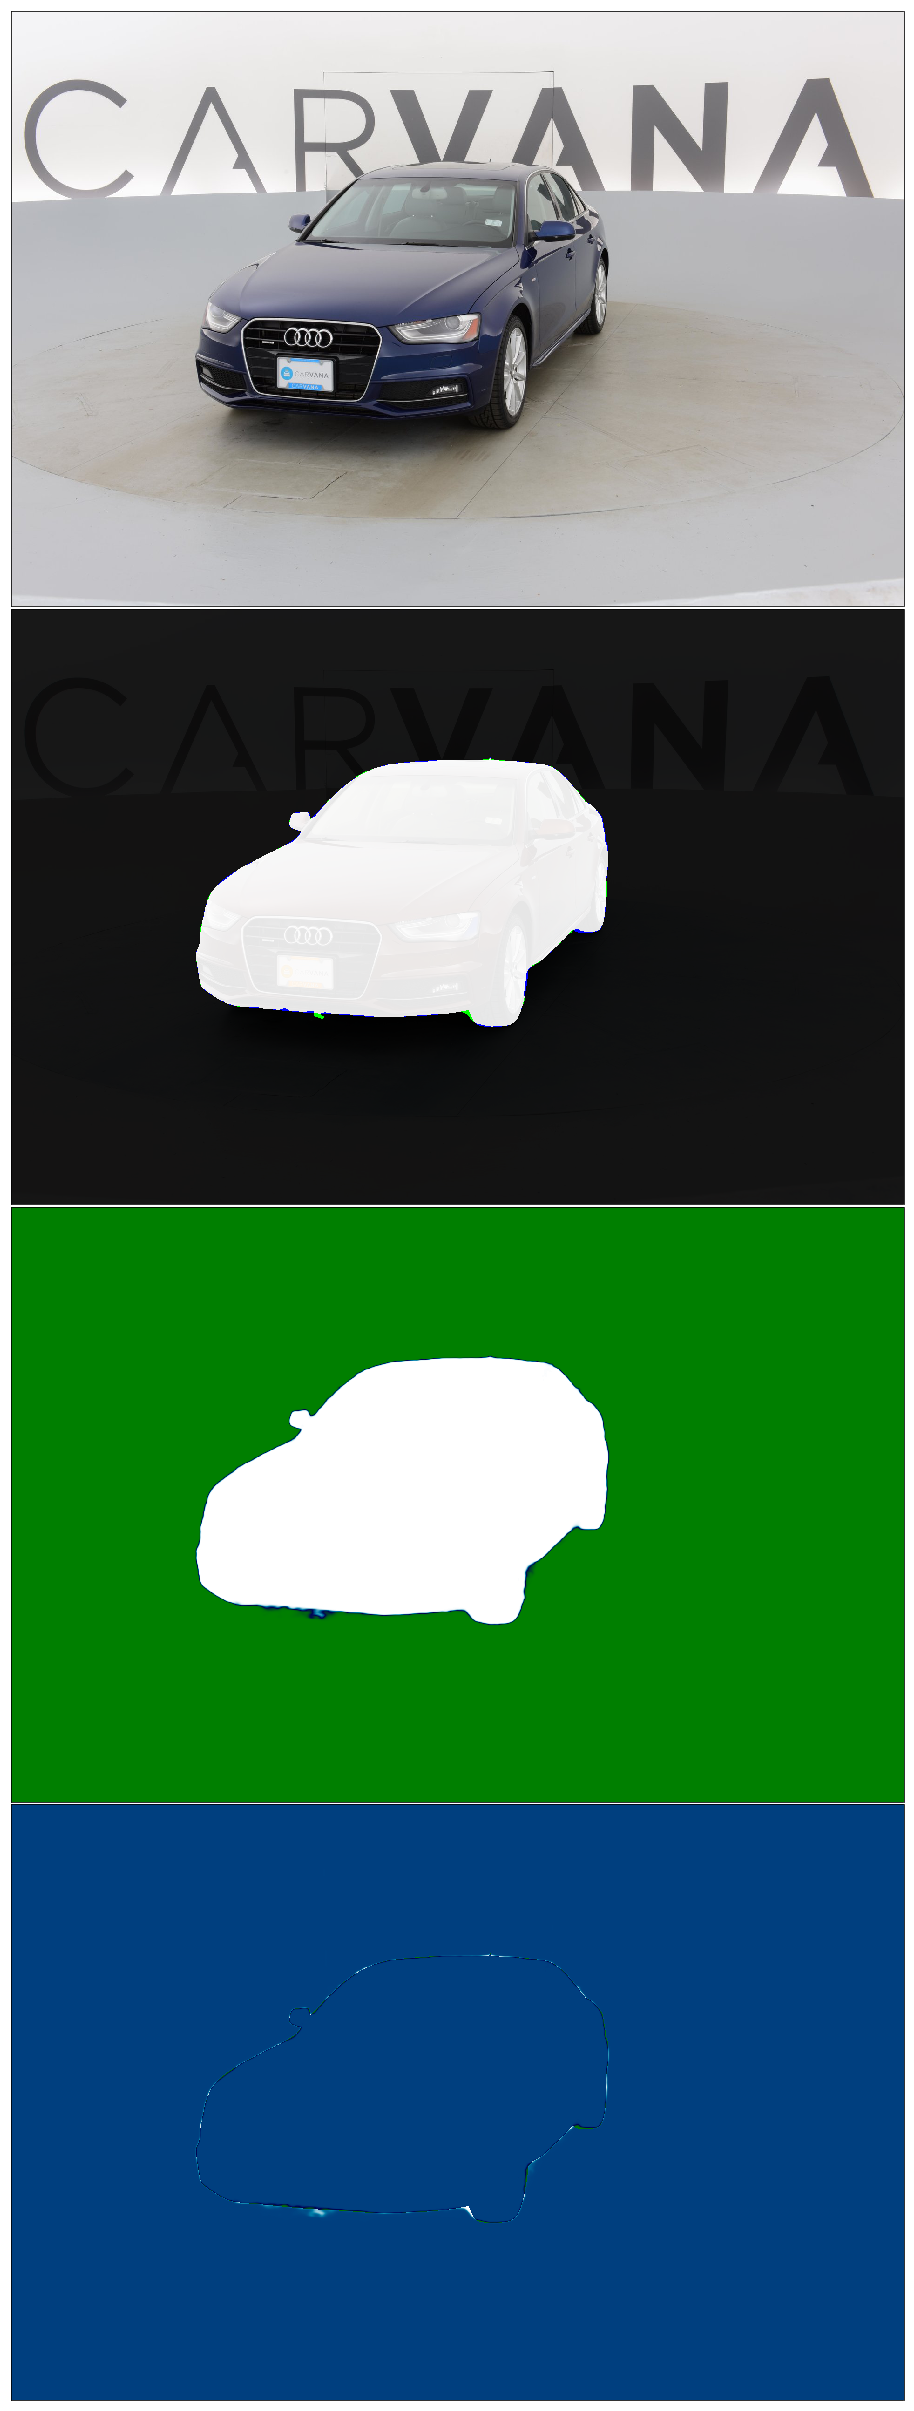

In [5]:
fig = plt.figure(figsize=(16, 44))

# initial image
fig.add_subplot(4, 1, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])

# predicted mask on image with highlighted errors
fig.add_subplot(4, 1, 2)

yprob = mask_prob
ypred = (yprob > 0.5).astype(np.float32)
ytrue = np.array(mask).astype(np.float32)

yfp = ypred * (1 - ytrue)
yfn = (1 - ypred) * ytrue
ytp = ypred * ytrue
ytn = (1 - ypred) * (1 - ytrue)

yshow = np.zeros_like(img).astype(np.float32)
yshow[..., 2] = yfn
yshow[..., 1] = yfp
yshow += ytp[..., np.newaxis] * (0.9 + 0.1 * (img / 255.).astype(np.float32))
yshow += ytn[..., np.newaxis] * (0.1 * (img / 255.).astype(np.float32))

plt.imshow(yshow)
plt.xticks([])
plt.yticks([])

# predicted mask
fig.add_subplot(4, 1, 3)
ploted_img = plt.imshow(yprob)
ploted_img.set_cmap('ocean')
plt.xticks([])
plt.yticks([])

# difference
fig.add_subplot(4, 1, 4)
ydiff = 0.5 + 0.5 * (yprob - ytrue)
ploted_img = plt.imshow(ydiff)
ploted_img.set_cmap('ocean')
plt.xticks([])
plt.yticks([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()